In [61]:
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import os

# Load the CSV files containing image labels
train_df = pd.read_csv('../Dataset/Labels/TrainLabels.csv')
test_df = pd.read_csv('../Dataset/Labels/TestLabels.csv')
validation_df = pd.read_csv('../Dataset/Labels/ValidationLabels.csv')

In [68]:
def graphs(history):
    #Accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    #Loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def augment_image(image):
    # Mirror flip
    # black_white = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    flipped = tf.image.flip_left_right(image)
    # Transpose flip
    transposed = tf.image.transpose(image)
    # Saturation
    saturated = tf.image.adjust_saturation(flipped, 3)
    # Brightness
    brightness = tf.image.adjust_brightness(saturated, 0.4)
    # Contrast
    contrast = tf.image.random_contrast(brightness, lower=0.0, upper=1.0)

    # Resize at the end
    # images = [flipped, transposed, saturated, brightness, contrast]
    return contrast


def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


def normalize_class_values(df):
    classes = ['Boredom', 'Engagement', 'Confusion', 'Frustration']
    max_possible_value = 3

    for index, row in df.iterrows():
        if row['Boredom'] == 1:
            df.at[index, 'Engagement'] = 2
        elif row['Boredom'] > 1:
            df.at[index, 'Engagement'] = 1

        if row['Frustration'] == 1:
            df.at[index, 'Frustration'] = 2
        elif row['Frustration'] == 2:
            df.at[index, 'Frustration'] = 3

        if row['Confusion'] == 1:
            df.at[index, 'Confusion'] = 2
        elif row['Confusion'] == 2:
            df.at[index, 'Confusion'] = 3
            
        # if row['Frustration'] > 30 or row['Confusion'] > 0 or row['Boredom'] > 0:
        #     df.at[index, 'Engagement'] = 1
            

    for class_name in classes:
        df[class_name] = round(df[class_name] / max_possible_value, 1)  # Round to 1 decimal place

    return df


# Update the 'ClipID' column in the CSV files to include the full path to each frame
def generate_full_paths(row, dataset_dir):
    video_name = row['ClipID'].strip()  # Remove any leading or trailing whitespaces
    full_paths = [os.path.join(dataset_dir, f'{video_name[:-4]}{i}.jpg') for i in range(0, 10)]
    return full_paths


def model():
    model = tf.keras.Sequential()

    model.add(kl.InputLayer(input_shape=(40, 122, 3)))
    model.add(kl.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.5))
    # First conv block
    model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.5))
    
    # Second conv block
    model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.5))
    
    # Third conv block
    model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(kl.BatchNormalization())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.5))
    
    # model.add(kl.Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu'))
    # model.add(kl.BatchNormalization())
    # model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # model.add(kl.Dropout(0.4))
    # Flatten
    model.add(kl.Flatten())
    
    # First FC
    model.add(kl.Dense(1024, activation='relu'))
    # Second Fc
    model.add(kl.Dense(512, activation='relu'))
    # model.add(kl.Dense(256))
    # Output FC with sigmoid at the end
    model.add(kl.Dense(4, activation='softmax', name='prediction'))
    
    return model


def saveModelWeights(model, test_acc):
    # Serialize and save model to JSON
    model_name = f'model_{test_acc:.4f}'
    model_json = model.to_json()
    with open(f'{model_name}.json', 'w') as json_file:
        json_file.write(model_json)
    # Save weights to JSON
    model.save_weights(f'{model_name}.h5')

In [69]:
# Load the CSV files containing image labels
train_df = pd.read_csv('../Dataset/Labels/TrainLabels.csv')
test_df = pd.read_csv('../Dataset/Labels/TestLabels.csv')
validation_df = pd.read_csv('../Dataset/Labels/ValidationLabels.csv')

# Specify K for KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True)

# Define image data generators for training, testing, and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Construct paths for each dataset
train_df['ClipID'] = train_df.apply(lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Train/face_mesh_rois'), axis=1)
test_df['ClipID'] = test_df.apply(lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Test/face_mesh_rois'), axis=1)
validation_df['ClipID'] = validation_df.apply(
    lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Validation/face_mesh_rois'), axis=1)

# Flatten the DataFrame to have one row per frame
train_df = train_df.explode('ClipID').reset_index(drop=True)
test_df = test_df.explode('ClipID').reset_index(drop=True)
validation_df = validation_df.explode('ClipID').reset_index(drop=True)

train_df_normalized = normalize_class_values(train_df)
test_df_normalized = normalize_class_values(test_df)
validation_df_normalized = normalize_class_values(validation_df)

# print(train_df_normalized['Engagement'].to_string(index=False))

classes = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=False
)

lrScheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [
    earlyStopping,
    lrScheduler,
]


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 40, 122, 64)       1792      
                                                                 
 batch_normalization_57 (Ba  (None, 40, 122, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 20, 61, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 20, 61, 64)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 20, 61, 128)       73856     
                                                                 
 batch_normalization_58 (Ba  (None, 20, 61, 128)     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 6590 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


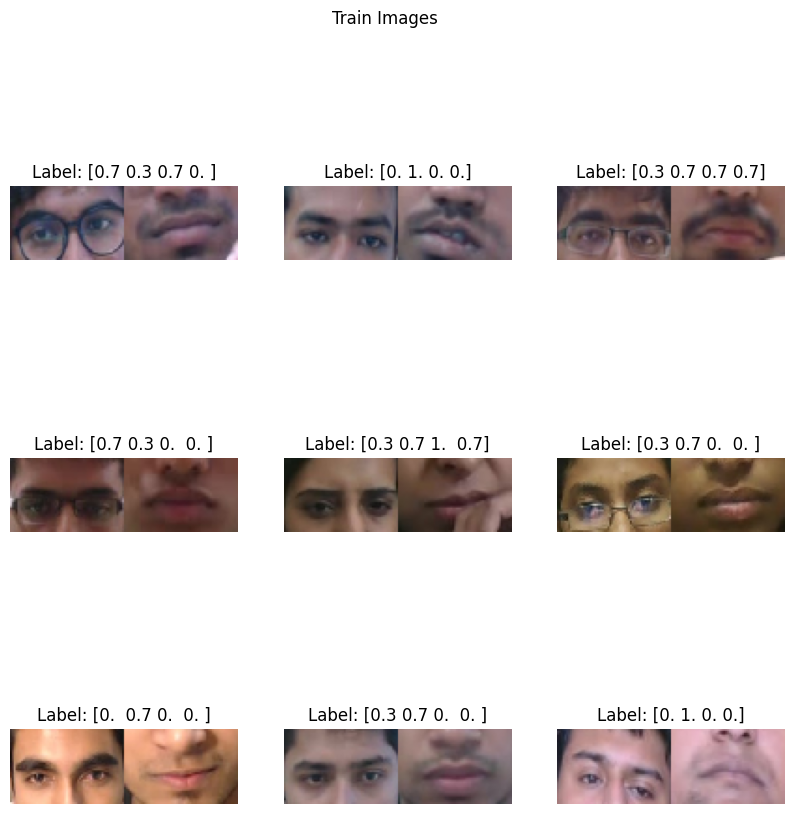

Found 15463 validated image filenames.
Found 4631 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2377 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 727 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/100
651/651 [==============================] - 232s 351ms/step - loss: 0.9094 - accuracy: 0.5783 - val_loss: 0.7235 - val_accuracy: 0.7262 - lr: 1.0000e-04
Epoch 2/100
651/651 [==============================] - 210s 323ms/step - loss: 0.7277 - accuracy: 0.6124 - val_loss: 1.1418 - val_accuracy: 0.4148 - lr: 1.0000e-04
Epoch 3/100
651/651 [==============================] - 210s 323ms/step - loss: 0.6428 - accuracy: 0.6499 - val_loss: 0.8480 - val_accuracy: 0.6644 - lr: 1.0000e-04
Epoch 4/100
651/651 [==============================] - 210s 322ms/step - loss: 0.6044 - accuracy: 0.6641 - val_loss: 0.9107 - val_accuracy: 0.3479 - lr: 1.0000e-04
Epoch 5/100
651/651 [==============================] - 210s 323ms/step - loss: 0.5806 - accuracy: 0.6855 - val_loss: 1.0413 - val_accuracy: 0.3597 - lr: 1.0000e-04
Epoch 6/100
651/651 [==============================] - 210s 323ms/step - loss: 0.5763 - accuracy: 0.6891 - val_loss: 0.6807 - val_accuracy: 0.5927 - lr: 1.0000e-04
Epoch 7/100
651/

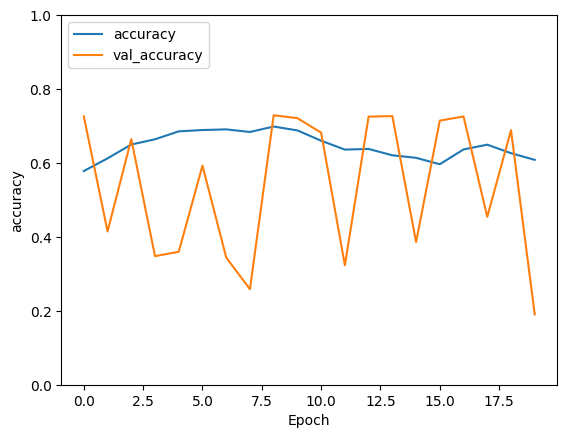

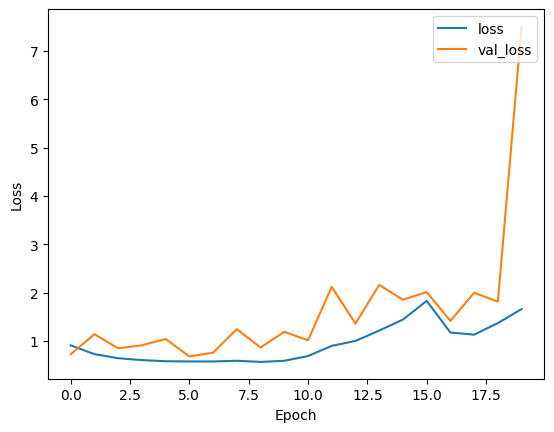

Training fold 2
Found 41617 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 6605 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


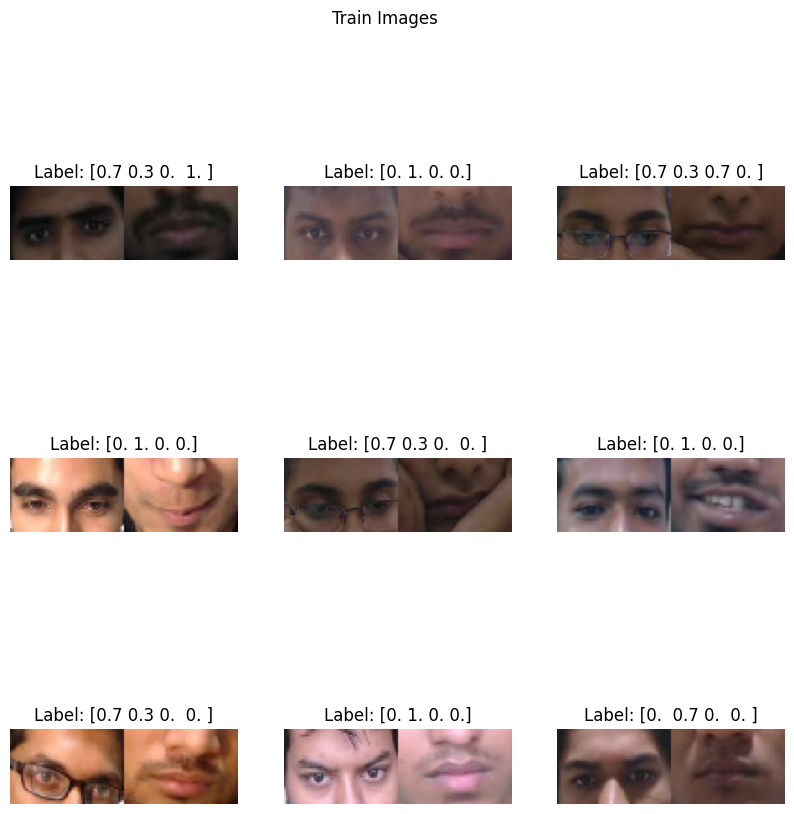

Found 15463 validated image filenames.
Found 4646 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2377 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 712 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


651/651 [==============================] - 212s 325ms/step - loss: 1.6058 - accuracy: 0.6198 - val_loss: 2.5616 - val_accuracy: 0.7236 - lr: 2.5000e-05
Epoch 2/100
651/651 [==============================] - 209s 321ms/step - loss: 2.1197 - accuracy: 0.6004 - val_loss: 7.5439 - val_accuracy: 0.7120 - lr: 2.5000e-05
Epoch 3/100
651/651 [==============================] - 209s 321ms/step - loss: 1.9382 - accuracy: 0.5996 - val_loss: 5.9210 - val_accuracy: 0.3399 - lr: 2.5000e-05
Epoch 4/100
651/651 [==============================] - 210s 322ms/step - loss: 2.4953 - accuracy: 0.5748 - val_loss: 4.8534 - val_accuracy: 0.2337 - lr: 2.5000e-05
Epoch 5/100
651/651 [==============================] - 209s 321ms/step - loss: 2.4650 - accuracy: 0.5866 - val_loss: 11.4509 - val_accuracy: 0.1750 - lr: 2.5000e-05
Epoch 6/100
651/651 [==============================] - 210s 322ms/step - loss: 2.7937 - accuracy: 0.5768 - val_loss: 6.4984 - val_accuracy: 0.2292 - lr: 2.5000e-05
Epoch 7/100
651/651 [======

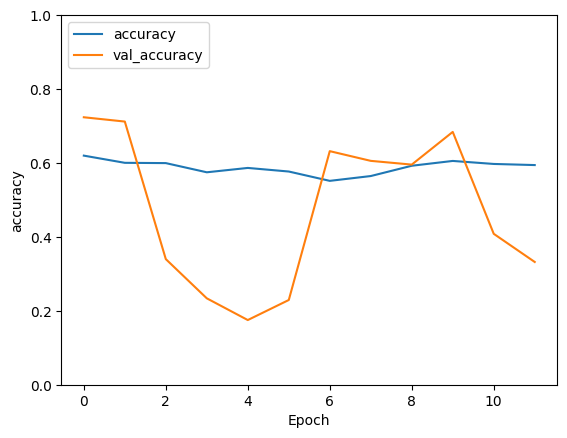

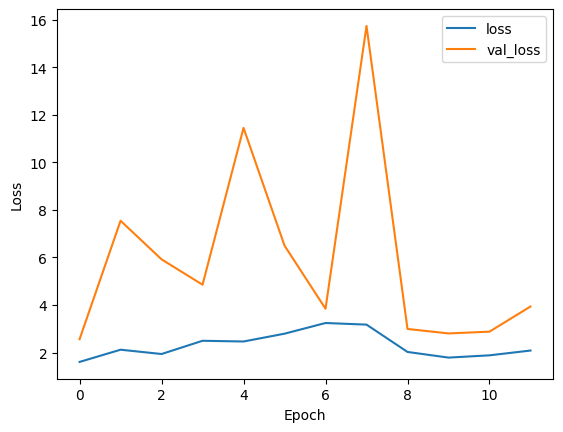

Training fold 3
Found 41674 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 6548 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


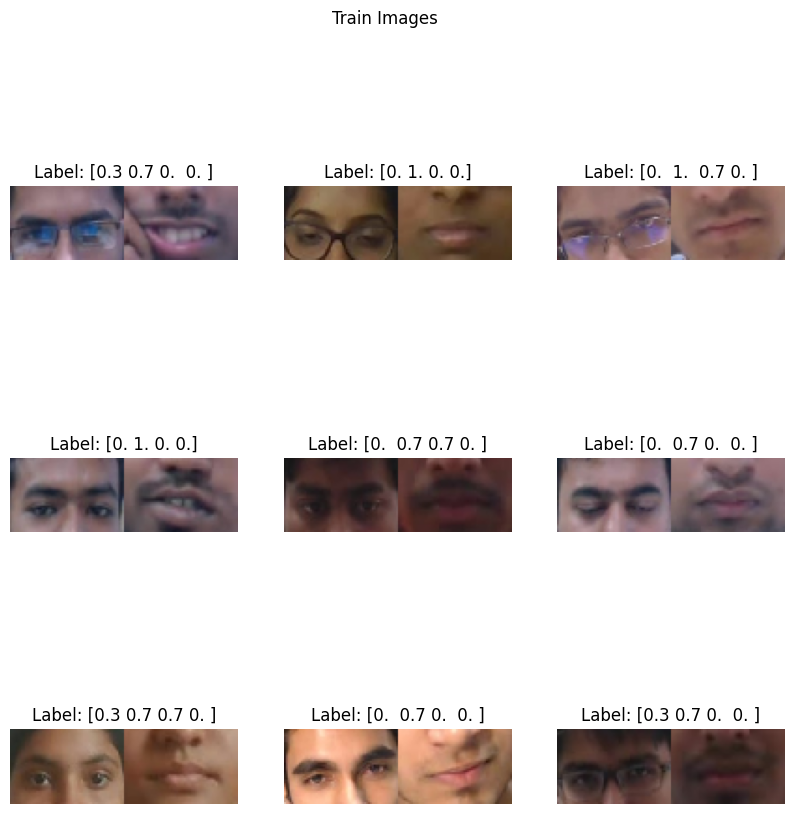

Found 15463 validated image filenames.
Found 4589 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2377 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 769 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


652/652 [==============================] - 213s 326ms/step - loss: 2.1527 - accuracy: 0.5805 - val_loss: 2.6491 - val_accuracy: 0.2441 - lr: 1.2500e-05
Epoch 2/100
652/652 [==============================] - 211s 324ms/step - loss: 2.1459 - accuracy: 0.5748 - val_loss: 2.8408 - val_accuracy: 0.1946 - lr: 1.2500e-05
Epoch 3/100
652/652 [==============================] - 211s 323ms/step - loss: 2.4124 - accuracy: 0.5753 - val_loss: 7.7878 - val_accuracy: 0.1475 - lr: 1.2500e-05
Epoch 4/100
652/652 [==============================] - 210s 322ms/step - loss: 2.4602 - accuracy: 0.5761 - val_loss: 5.0720 - val_accuracy: 0.6010 - lr: 1.2500e-05
Epoch 5/100
652/652 [==============================] - 210s 322ms/step - loss: 2.6858 - accuracy: 0.5675 - val_loss: 2.7136 - val_accuracy: 0.6415 - lr: 1.2500e-05
Epoch 6/100
652/652 [==============================] - 213s 327ms/step - loss: 2.6138 - accuracy: 0.5699 - val_loss: 3.7885 - val_accuracy: 0.6420 - lr: 1.2500e-05
Epoch 7/100
652/652 [=======

KeyboardInterrupt: 

In [70]:
model = model()
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df_normalized)):
    print(f"Training fold {fold + 1}")

    train_fold = train_df_normalized.iloc[train_idx]
    val_fold = train_df_normalized.iloc[val_idx]
 
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_fold,
        x_col='ClipID',
        y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
        target_size=(40, 122),
        batch_size=64,
        class_mode='raw',
        shuffle=True,
        preprocessing_function=augment_image
    )
    
    images, labels = next(train_generator)
    plot_images(images, labels, 'Train Images')
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df_normalized,
        x_col='ClipID',
        y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
        target_size=(40, 122),
        batch_size=64,
        class_mode='raw',
        shuffle=True,
    )
    
    # images, labels = next(test_generator)
    # plot_images(images, labels, 'Test Images')
    
    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=val_fold,
        x_col='ClipID',
        y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
        target_size=(40, 122),
        batch_size=64,
        class_mode='raw',
        shuffle=True,
    )
    
    # images, labels = next(validation_generator)
    # plot_images(images, labels, 'Validation Images')
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    
    # Evaluate the model on the test set
    test_images, test_labels = next(test_generator)
    test_predictions = model.predict(test_images)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
    print(f'Test accuracy: {test_acc}')
    
    graphs(history)
    
    saveModelWeights(model, test_acc)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
 
# graphs(history)

# saveModelWeights(model, test_acc)

2/2 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

     Boredom       0.00      0.00      0.00         8
  Engagement       0.80      0.90      0.85        52
   Confusion       0.00      0.00      0.00         3
 Frustration       0.00      0.00      0.00         1

    accuracy                           0.73        64
   macro avg       0.20      0.23      0.21        64
weighted avg       0.65      0.73      0.69        64


/var/folders/wx/c2fc49pd4s7fq23msz0ypksh0000gn/T/ipykernel_15138/1827476047.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


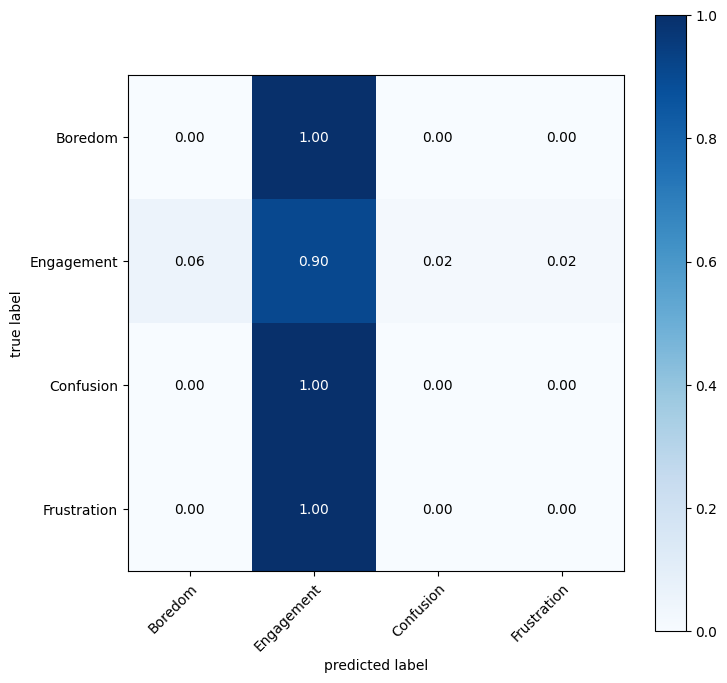

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

pred_test_labels = model.predict(test_images)

conf_mat = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred_test_labels, axis=1))

emotions = {0: 'Boredom', 1: 'Engagement', 2: 'Confusion', 3: 'Frustration'}

#Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()
#Print classifation report
print(classification_report(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1), target_names=emotions.values()))